In [28]:
#
# In this notebook we download and plot example systems
#
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import wget
import os
from scipy.ndimage import label
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from os.path import basename
from src.regions import *
from src.plotting import * 
from src.pf_stats import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Load region to pull examples from
CORE_THRESH = 10
regions = [
    afc_region(), 
    cio_region(), 
    wmp_region(), 
    epo_region(),
]

pf_stats = pd.concat(
    [load_pf_stats(r, maxpr_min=CORE_THRESH) for r in regions]
)


area = pf_stats['num_pixels']*25
loc = pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_precip_8conn'] / pf_stats['total_precip']
maxpr = pf_stats['max_precip']

high_area_id = (10_000<=area) & (area<=11_000)
low_area_id = (1000<=area) & (area<=1100)

high_loc_id = (0.75<=loc) & (loc<=0.9)
low_loc_id = (0.3<=loc) & (loc<=0.45)

extreme_id = maxpr >= 80

regime_dict = {
    'high_area_high_loc': pf_stats[high_area_id & high_loc_id & extreme_id],
    'high_area_low_loc' : pf_stats[high_area_id & low_loc_id & extreme_id],
    'low_area_high_loc' : pf_stats[low_area_id  & high_loc_id & extreme_id],
    'low_area_low_loc'  : pf_stats[low_area_id  & low_loc_id & extreme_id]
}

for regime, data in regime_dict.items():
    print(regime)
    assert(data.shape[0]>0)

high_area_high_loc
high_area_low_loc
low_area_high_loc
low_area_low_loc


In [33]:
loc[high_area_id & low_loc_id & extreme_id]

346833     0.448154
352205     0.408126
382990     0.352465
432828     0.349694
533688     0.354084
10182      0.415014
95826      0.362046
161954     0.391136
272343     0.379499
686114     0.437599
49271      0.437381
1094246    0.443483
1162322    0.415702
dtype: float64

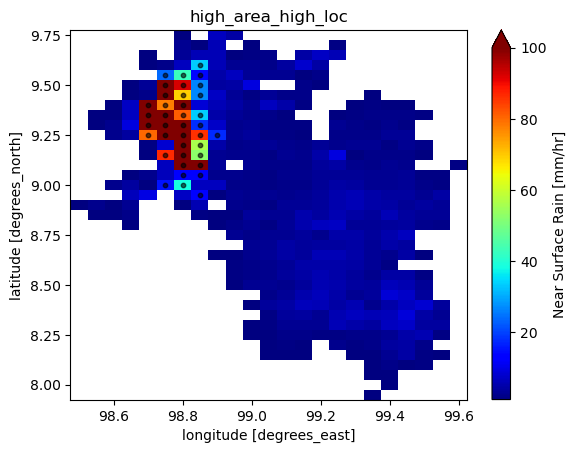

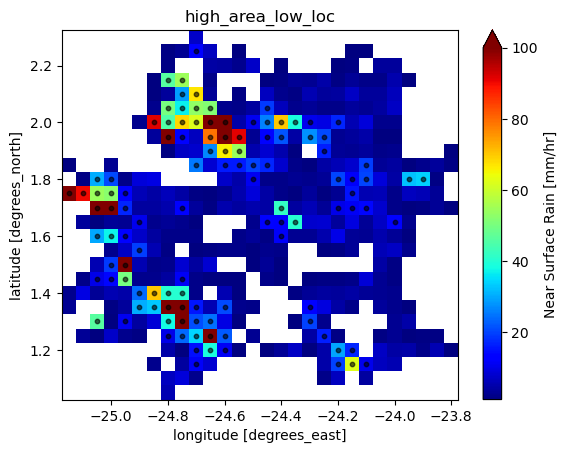

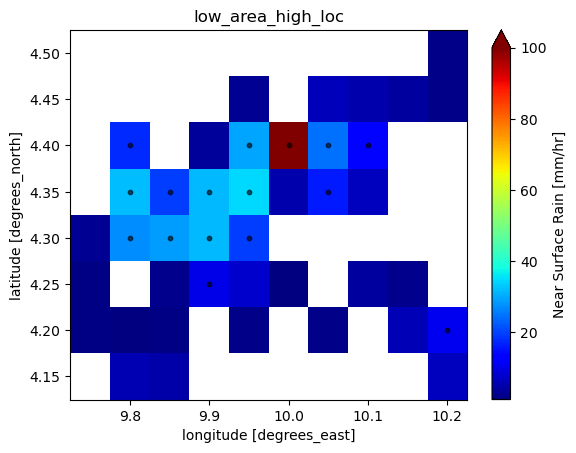

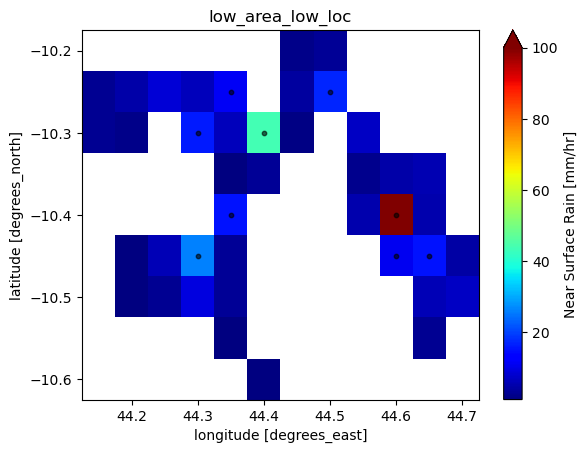

In [30]:
pf_ids = [0, 1, 1, 1]
for pf_id, (regime, df) in zip(pf_ids, regime_dict.items()):

    #
    # Download file and extract the relevant PF
    file = df['gpm_filename'].iloc[pf_id]
    pf_id = df['feature_id'].iloc[pf_id]
    region_name = file.split('_')[-1].split('.')[0]
    url = f"http://gpm.atmos.washington.edu/{'/'.join(file.split('/')[5:])}"
    out_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}_fullfile.nc'
    if os.path.exists(out_filename):
        os.remove(out_filename) # if exist, remove it directly
    wget.download(url, out_filename)

    swath_data = xr.open_dataset(out_filename).squeeze('time')
    rainy_mask = swath_data['near_surf_rain'] >= 1
    structure = [[1,1,1],[1,1,1],[1,1,1]]
    pf_mask = label(rainy_mask, structure=structure)[0]==pf_id
    pf_mask = rainy_mask.copy(data=pf_mask)
    pf_data = swath_data.where(pf_mask, drop=True)

    pf_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}.nc'
    pf_data.to_netcdf(pf_filename)
    
    #
    # Plot the data
    #    
    fig, ax = plt.subplots()

    pf_data.near_surf_rain.plot(
        ax=ax, 
        cmap=plt.cm.jet, 
        norm=colors.Normalize(vmin=1, vmax=100)
    )
    ax.set_title(regime)
    
    # Highlight core pixels
    precip = pf_data['near_surf_rain']
    mask = precip >= CORE_THRESH
    lat_vals = precip.coords['lat'].values
    lon_vals = precip.coords['lon'].values
    LON, LAT = np.meshgrid(lon_vals, lat_vals)

    ax.scatter(
        LON[mask], 
        LAT[mask], 
        s=10,          # marker size
        c='black',       # marker color
        alpha=0.6,     # some transparency
        label='>5mm/hr'
    )


In [11]:
df['num_pixels']

120634    68
270910    68
310404    67
462469    67
531884    67
605508    67
56103     68
273496    68
Name: num_pixels, dtype: int64